# Example 2 - Convolutions for larger images

In Example 1, we trained a basic autoencoder with some dense layers to reconstruct 32x32x3 images. Dense layers won't scale for larger images, as the number of parameters is large. The model in Example 1 had 1,182,912 trainable parameters, which is already quite large!

In this notebook, we will use convolution layers to train an autoencoder, to show we can achieve similar performance with much fewer parameters -- and with an architecture where the number of parameters scales with image size!

In [1]:
import tensorflow as tf


from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Identity, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping

2024-01-16 12:36:29.687575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 12:36:29.687619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 12:36:29.689146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 12:36:29.697008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 12:36:30.565188: W tensorflow/compiler/tf2

In [2]:
from utils import get_preprocessed_emoji, plot_loss, evaluate_autoencoder

In [3]:
x_train, x_test = get_preprocessed_emoji(resized_size=32)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [45]:
inferred_size = x_train.shape[1]

encoder = tf.keras.Sequential([
    Input(shape=(inferred_size, inferred_size, 3)),

    Conv2D(32,kernel_size=3,activation='relu',padding='same',strides=1),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    Conv2D(64,kernel_size=3,activation='relu',padding='same',strides=1),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    Conv2D(12,kernel_size=3,activation='relu',padding='same',strides=1), 
    MaxPooling2D((2, 2), padding='same'),
])

# deconvolution -> decoding 
decoder = tf.keras.Sequential([
    UpSampling2D((2, 2)),
    Conv2D(64,kernel_size=3,strides=1,activation='relu',padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),
    Conv2D(32,kernel_size=3,strides=1,activation='relu',padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3,kernel_size=(3,3),activation='sigmoid',padding='same')
])


autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

0epoch [00:00, ?epoch/s]

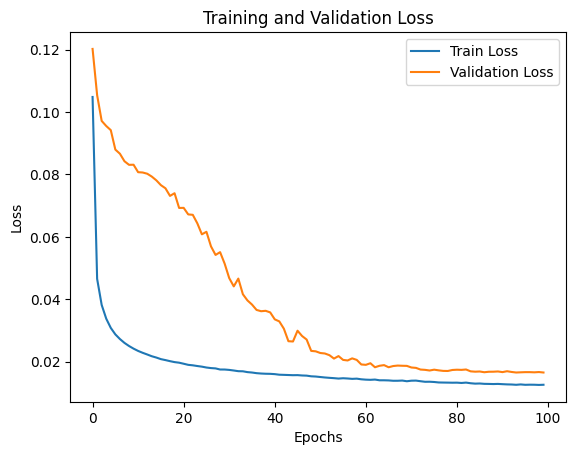

In [46]:
history = autoencoder.fit(
    x_train, x_train, 
    epochs=100, batch_size=256, validation_data=(x_test, x_test), 

    # Only show progress for epochs:
    verbose=0,
    callbacks=[TqdmCallback(verbose=0)],
)

plot_loss(history)

In [37]:
autoencoder.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_24 (Sequential)  (None, 4, 4, 12)          26700     
                                                                 
 sequential_25 (Sequential)  (None, 32, 32, 3)         26563     
                                                                 
Total params: 53263 (208.06 KB)
Trainable params: 52943 (206.81 KB)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


## Evaluate the results

Some quick observations:
- This model has only 53k trainable parameters (about 50x reduction vs 1.2M for the Dense model in Example 1).
- The training and validation losses are closer to each other, suggesting there is less overfitting.


63/63 [==============================] - 0s 3ms/step
Bottleneck layer size: 192, equivalent_downsample=8
Recovered MSE: 0.01282653771340847
Baseline MSE:  0.022099271416664124
Originals:


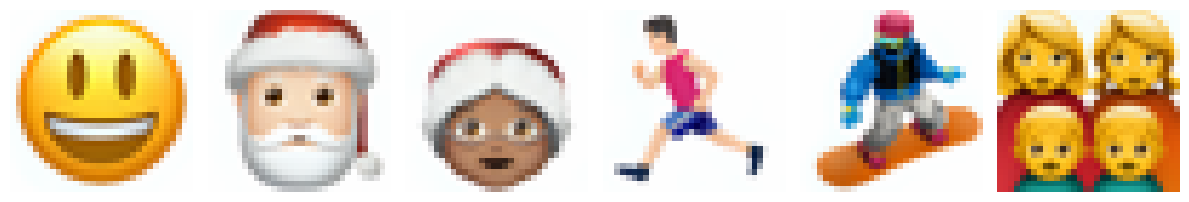

AE Recovered:


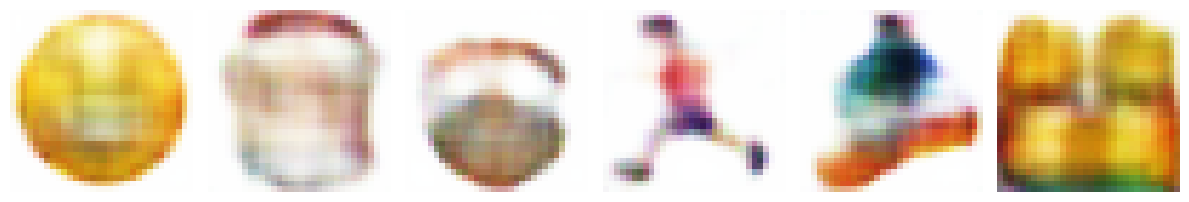

Downsample/Upsample baseline:


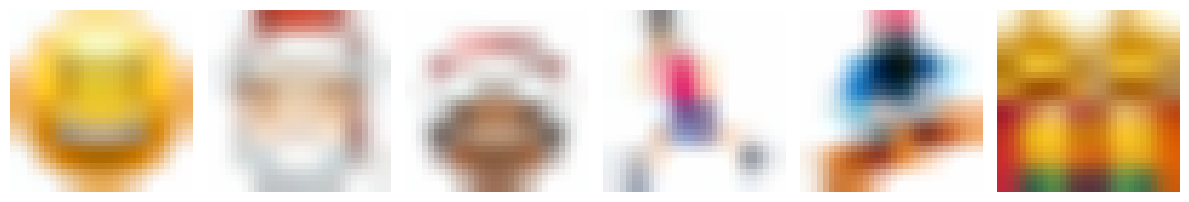

In [47]:
evaluate_autoencoder(autoencoder, x_train)

### Comparing with the downsampling baseline

Here the MSE reconstruction errors of the autoencoder appear much stronger than the baseline. However, to my eyes, the reconstructions of the baseline look slightly better.

Ignore for a moment where the reconstructions come from -- the interesting thing is that, we have two sets of reconstructions, and (a) our loss function tells us that one is better, but (b) our eyes tell us the other is better. 

So, what's going on? Intuitively, (a) MSE loss compares each pixel brightness independently and aggregates the differences, whereas (b) human vision focuses on shapes and contours.

In the next example, we will explore a different loss function, SSIM, that tends to correlate better with human perception.